In [ ]:

# Notebook: asos_graphreturns_modeling_advanced.ipynb
# Requirements: pandas, numpy, scikit-learn, matplotlib, seaborn, joblib, xgboost
# Install: pip install pandas numpy scikit-learn matplotlib seaborn joblib xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [ ]:
%pip install xgboost

In [ ]:
# -------- 1) Load dataset --------
df = joblib.load("/content/merged_events_train.joblib")
print("✅ Loaded dataset with shape:", df.shape)

✅ Loaded dataset with shape: (1369133, 77)


In [ ]:
# -------- 2) Define label and features --------
label_col = "isreturned" if "isreturned" in df.columns else "label"
X = df.drop(columns=[label_col])
y = df[label_col].astype(int)

In [ ]:
# -------- 3) Identify feature types --------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("📊 Numeric features:", len(numeric_cols))
print("🔠 Categorical features:", len(categorical_cols))

📊 Numeric features: 73
🔠 Categorical features: 3


In [ ]:
# -------- 4) Preprocessing pipeline --------
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, categorical_cols)
], remainder="drop")

In [ ]:
# -------- 5) Train/test split --------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# -------- 6) Transform features --------
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)
feature_names = preprocessor.get_feature_names_out()

In [ ]:
# -------- 7) Define models --------
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}


🔧 Training RandomForest...

📋 RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68    122381
           1       0.74      0.77      0.76    151446

    accuracy                           0.73    273827
   macro avg       0.72      0.72      0.72    273827
weighted avg       0.72      0.73      0.72    273827



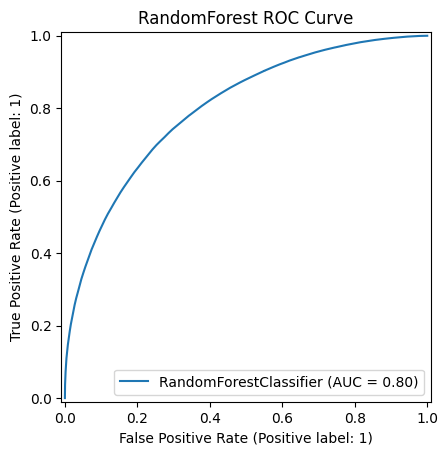


🔧 Training LogisticRegression...

📋 LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.70    122381
           1       0.75      0.79      0.77    151446

    accuracy                           0.74    273827
   macro avg       0.74      0.73      0.73    273827
weighted avg       0.74      0.74      0.74    273827



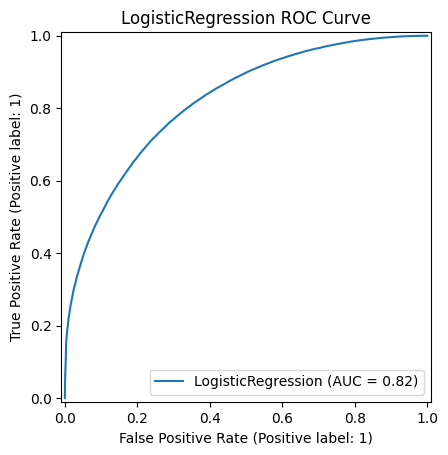


🔧 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:29:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📋 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70    122381
           1       0.75      0.80      0.77    151446

    accuracy                           0.74    273827
   macro avg       0.74      0.74      0.74    273827
weighted avg       0.74      0.74      0.74    273827



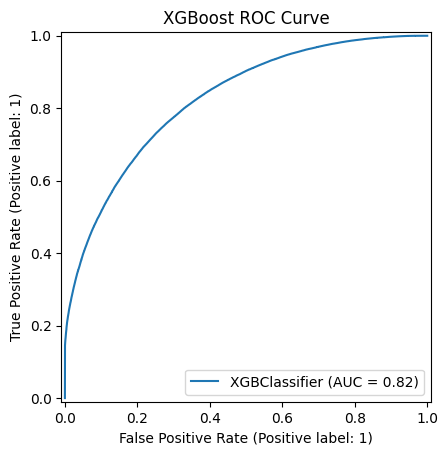

In [ ]:
# -------- 8) Train and evaluate models --------
results = []

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "ROC AUC": auc
    })

    print(f"\n📋 {name} Classification Report:")
    print(classification_report(y_test, y_pred))

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()


📊 Model Comparison:
                Model  Accuracy  Precision    Recall   ROC AUC
2             XGBoost  0.742147   0.751320  0.797869  0.824915
1  LogisticRegression  0.739072   0.749484  0.793425  0.820280
0        RandomForest  0.725122   0.741885  0.771371  0.800798


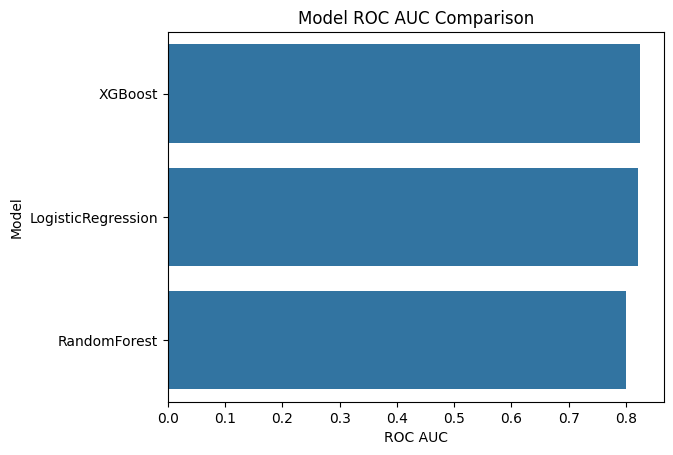

In [ ]:
# -------- 9) Compare models --------
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison:")
print(results_df.sort_values(by="ROC AUC", ascending=False))

sns.barplot(x="ROC AUC", y="Model", data=results_df.sort_values(by="ROC AUC", ascending=False))
plt.title("Model ROC AUC Comparison")
plt.show()



🔥 Top Features for RandomForest:
                                  feature  importance
8                 num__customerreturnrate    0.184396
0                    num__hash(variantid)    0.075945
1                   num__hash(customerid)    0.060943
7                 num__returnspercustomer    0.049700
2                        num__customer_id    0.049076
6                   num__salespercustomer    0.045105
3                        num__yearofbirth    0.041011
38                 num__productreturnrate    0.039969
14  num__customerid_level_return_code_d.1    0.024661
34                       num__avggbpprice    0.023909
36                   num__salesperproduct    0.020682
18    num__customerid_level_return_code_i    0.018877
32                   num__hash(productid)    0.018695
19    num__customerid_level_return_code_j    0.018655
35                  num__avgdiscountvalue    0.018538
33                 num__hash(supplierref)    0.018488
50     num__variantid_level_return_code_k    0.0

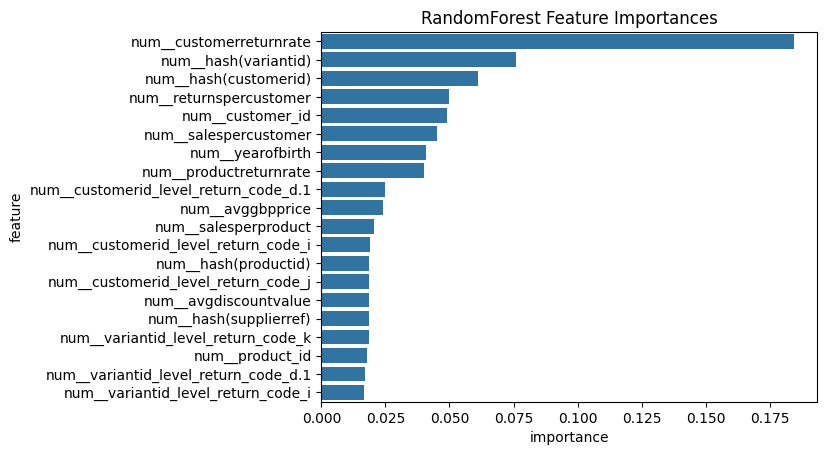


🔥 Top Features for XGBoost:
                                feature  importance
8               num__customerreturnrate    0.580138
82         cat__shippingcountry_missing    0.065793
38               num__productreturnrate    0.058001
4                           num__ismale    0.012673
28                       num__country_g    0.012598
72                   num__producttype_k    0.011658
56                         num__brand_e    0.010048
50   num__variantid_level_return_code_k    0.009502
19  num__customerid_level_return_code_j    0.009499
63                   num__producttype_b    0.009385
18  num__customerid_level_return_code_i    0.007761
64                   num__producttype_c    0.007327
49   num__variantid_level_return_code_j    0.007265
36                 num__salesperproduct    0.007073
79       cat__shippingcountry_Country_G    0.006777
66                   num__producttype_e    0.006687
59                         num__brand_i    0.006363
71                   num__productty

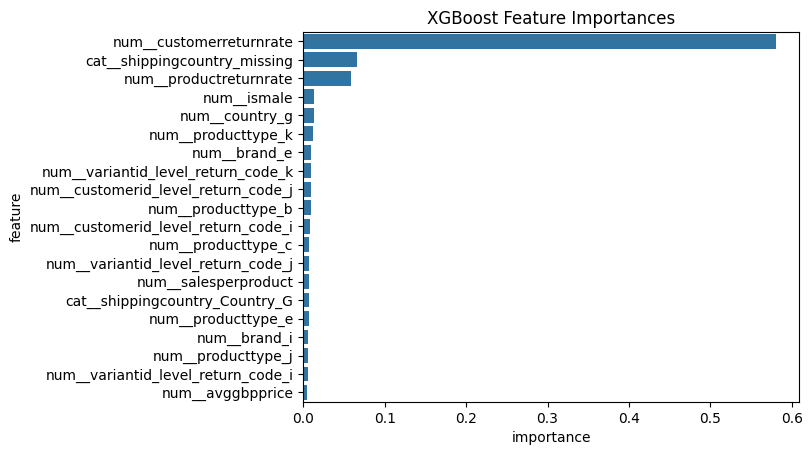

In [ ]:
# -------- 10) Feature importance (if available) --------
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feat_df = pd.DataFrame({"feature": feature_names, "importance": importances})
        top_feats = feat_df.sort_values(by="importance", ascending=False).head(20)

        print(f"\n🔥 Top Features for {name}:")
        print(top_feats)

        sns.barplot(x="importance", y="feature", data=top_feats)
        plt.title(f"{name} Feature Importances")
        plt.show()

In [ ]:
# -------- 11)SHAP Force Plot for XGBoost in Colab --------
import shap
import pandas as pd # Import pandas

# Initialize SHAP JS for interactive plots
shap.initjs()

# Create SHAP explainer and compute SHAP values
print("\n🧠 SHAP Analysis for XGBoost...")
# Ensure X_test is a DataFrame for iloc and feature names
if not isinstance(X_test, pd.DataFrame):
    # Need feature_names to create DataFrame with column names
    # Assuming feature_names is available from previous preprocessing steps
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
else:
    X_test_df = X_test


explainer = shap.Explainer(models["XGBoost"], X_test_df)
shap_values = explainer(X_test_df)


🧠 SHAP Analysis for XGBoost...


100%|===================| 273597/273827 [15:15<00:00]       

100%|===================| 273602/273827 [15:11<00:00]       

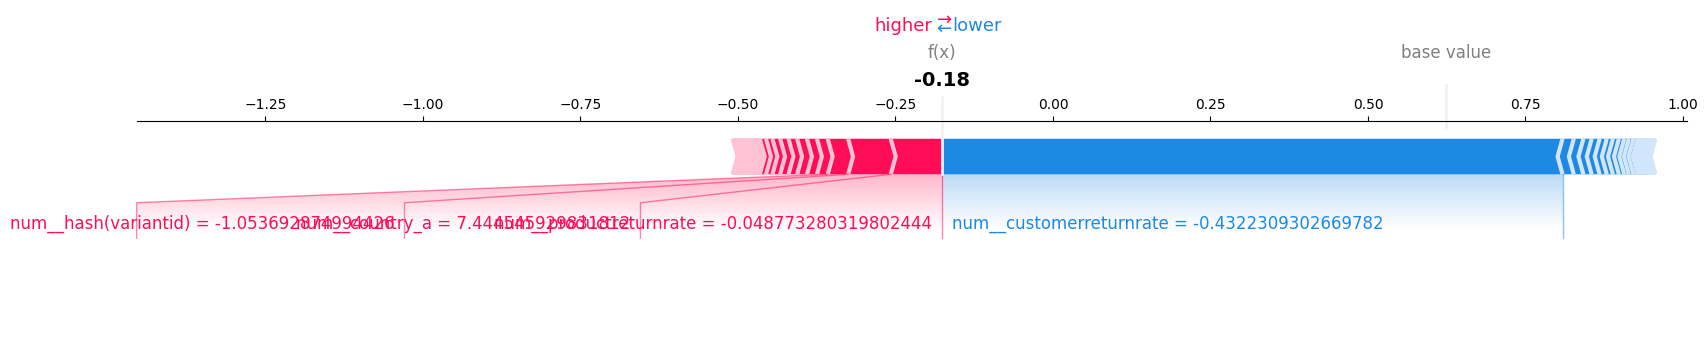

✅ SHAP force plot saved as 'shap_force_plot.png' and 'shap_force_plot.html'


In [ ]:
# Get explanation object for all test data
shap_values = explainer(X_test_df)  # returns a shap.Explanation object

i = 0  # index to explain

# Matplotlib/static plot
fig = shap.force_plot(shap_values[i], matplotlib=True)
plt.savefig("shap_force_plot.png", bbox_inches='tight')
plt.close()

# Interactive plot
interactive_plot = shap.force_plot(shap_values[i])
shap.save_html("shap_force_plot.html", interactive_plot)

print("✅ SHAP force plot saved as 'shap_force_plot.png' and 'shap_force_plot.html'")



🌌 PCA Visualization...


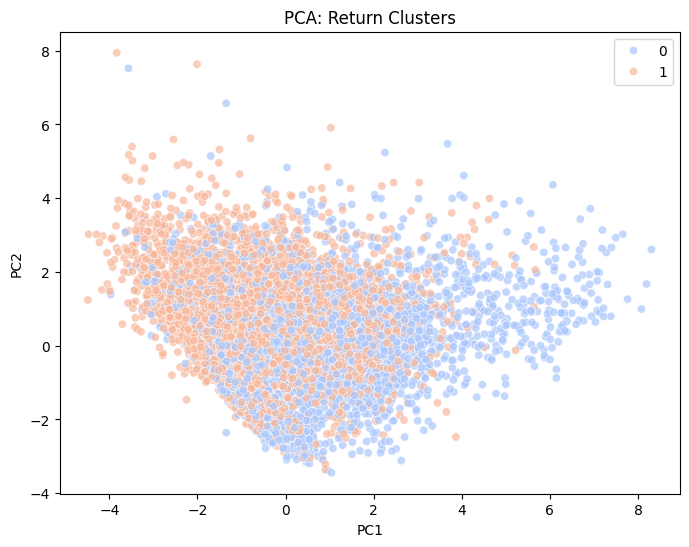

In [ ]:
# -------- 13) PCA & t-SNE Visualization --------
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Limit sample size for visualization

MAX_TSNE_SAMPLES = 3000
MAX_PCA_SAMPLES = 10000

# PCA Visualization
print("\n🌌 PCA Visualization...")
if len(X_test) > MAX_PCA_SAMPLES:
    idx_pca = np.random.choice(len(X_test), MAX_PCA_SAMPLES, replace=False)
    X_pca_input = X_test[idx_pca]
    y_pca_input = np.array(y_test)[idx_pca]
else:
    X_pca_input = X_test
    y_pca_input = y_test

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca_input)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_pca_input, palette="coolwarm", alpha=0.7)
plt.title("PCA: Return Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


🌌 t-SNE Visualization...


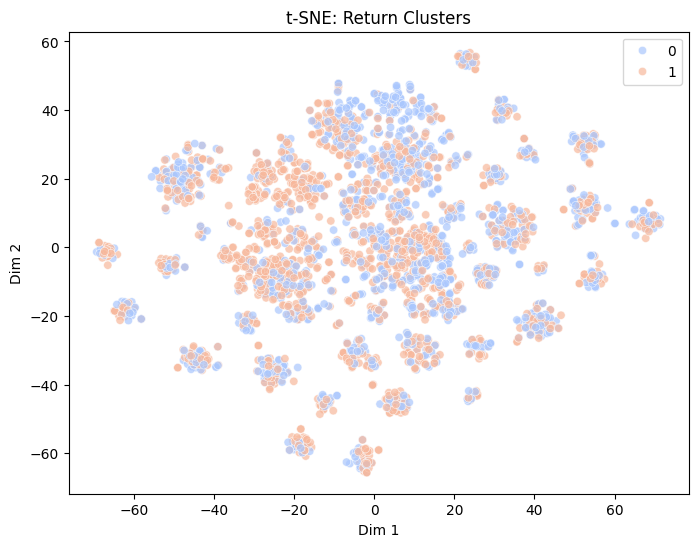

In [ ]:

# t-SNE Visualization (sampled)
print("\n🌌 t-SNE Visualization...")
if len(X_test) > MAX_TSNE_SAMPLES:
    idx_tsne = np.random.choice(len(X_test), MAX_TSNE_SAMPLES, replace=False)
    X_tsne_input = X_test[idx_tsne]
    y_tsne_input = np.array(y_test)[idx_tsne]
else:
    X_tsne_input = X_test
    y_tsne_input = y_test

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_tsne_input, palette="coolwarm", alpha=0.7)
plt.title("t-SNE: Return Clusters")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In [ ]:
# -------- 14) Export Predictions for Business Review --------
print("\n📤 Exporting predictions for business review...")

# Choose best model (e.g., XGBoost)
best_model = models["XGBoost"]
y_pred_final = best_model.predict(X_test)
y_proba_final = best_model.predict_proba(X_test)[:, 1]

# Combine with original test data
results_export = X_test_raw.copy()
results_export["Predicted_Return"] = y_pred_final
results_export["Return_Probability"] = y_proba_final
results_export["Actual_Return"] = y_test.values

# Save to CSV
results_export.to_csv("asos_return_predictions.csv", index=False)
print("✅ Exported to 'asos_return_predictions.csv'")



📤 Exporting predictions for business review...
✅ Exported to 'asos_return_predictions.csv'


## Summary

The modeling process involved several key steps:

1.  **Data Loading**: The dataset was loaded from a `.joblib` file.
2.  **Label and Feature Definition**: The target variable (`isreturned` or `label`) was identified, and the dataset was split into features (`X`) and the target variable (`y`).
3.  **Feature Type Identification**: Features were classified as either numeric or categorical.
4.  **Preprocessing Pipeline**: A preprocessing pipeline was constructed using `ColumnTransformer`. This pipeline included:
    *   **Numeric Features**: Imputation with the median and scaling using `StandardScaler`.
    *   **Categorical Features**: Imputation with a constant value ('missing') and one-hot encoding using `OneHotEncoder`.
5.  **Train/Test Split**: The data was split into training and testing sets using `train_test_split`, with stratification to maintain the proportion of the target variable.
6.  **Feature Transformation**: The preprocessing pipeline was applied to the training and testing data to transform the features.
7.  **Model Definition**: Several classification models were defined, including RandomForest, Logistic Regression, and XGBoost.
8.  **Model Training and Evaluation**: Each defined model was trained on the preprocessed training data and evaluated on the test set using metrics such as Accuracy, Precision, Recall, and ROC AUC. Classification reports and ROC curves were generated for each model.